Step 1: Import library

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np                           
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
    ttest_ind,
    levene,
    chi2_contingency,
    skew,
    kurtosis,
    pearsonr,
    f_oneway
)
import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [8]:
df = pd.read_csv("household.csv")

In [9]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

                           
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [ ]:
df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [12]:
df_hour.head(1)

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355,248.78,273.720891


Step 3. Implement models

Inferential Statistics

In [ ]:
weather_features = ['temp', 'feels_like', 'humidity', 'pressure', 'speed']

target_feature = 'active_power'

results_list = []

for var in weather_features:
    if var in df_hour.columns:
        valid_data = df_hour[[var, target_feature]].dropna()
        corr, p_value = pearsonr(valid_data[var], valid_data[target_feature])
        results_list.append({
            'Variable': var,
            'Correlation (r)': corr,
            'p-value': p_value
        })

df_results = pd.DataFrame(results_list)

df_results['Correlation (r)'] = df_results['Correlation (r)'].round(3)
df_results['p-value'] = df_results['p-value'].round(3)

print("--- Pearson Correlation Results ---")
df_results


--- Pearson Correlation Results ---


,Variable,Correlation (r),p-value
0,temp,0.433,0.0
1,feels_like,0.437,0.0
2,humidity,-0.139,0.0
3,pressure,-0.124,0.0
4,speed,0.161,0.0


---Scatterplot---


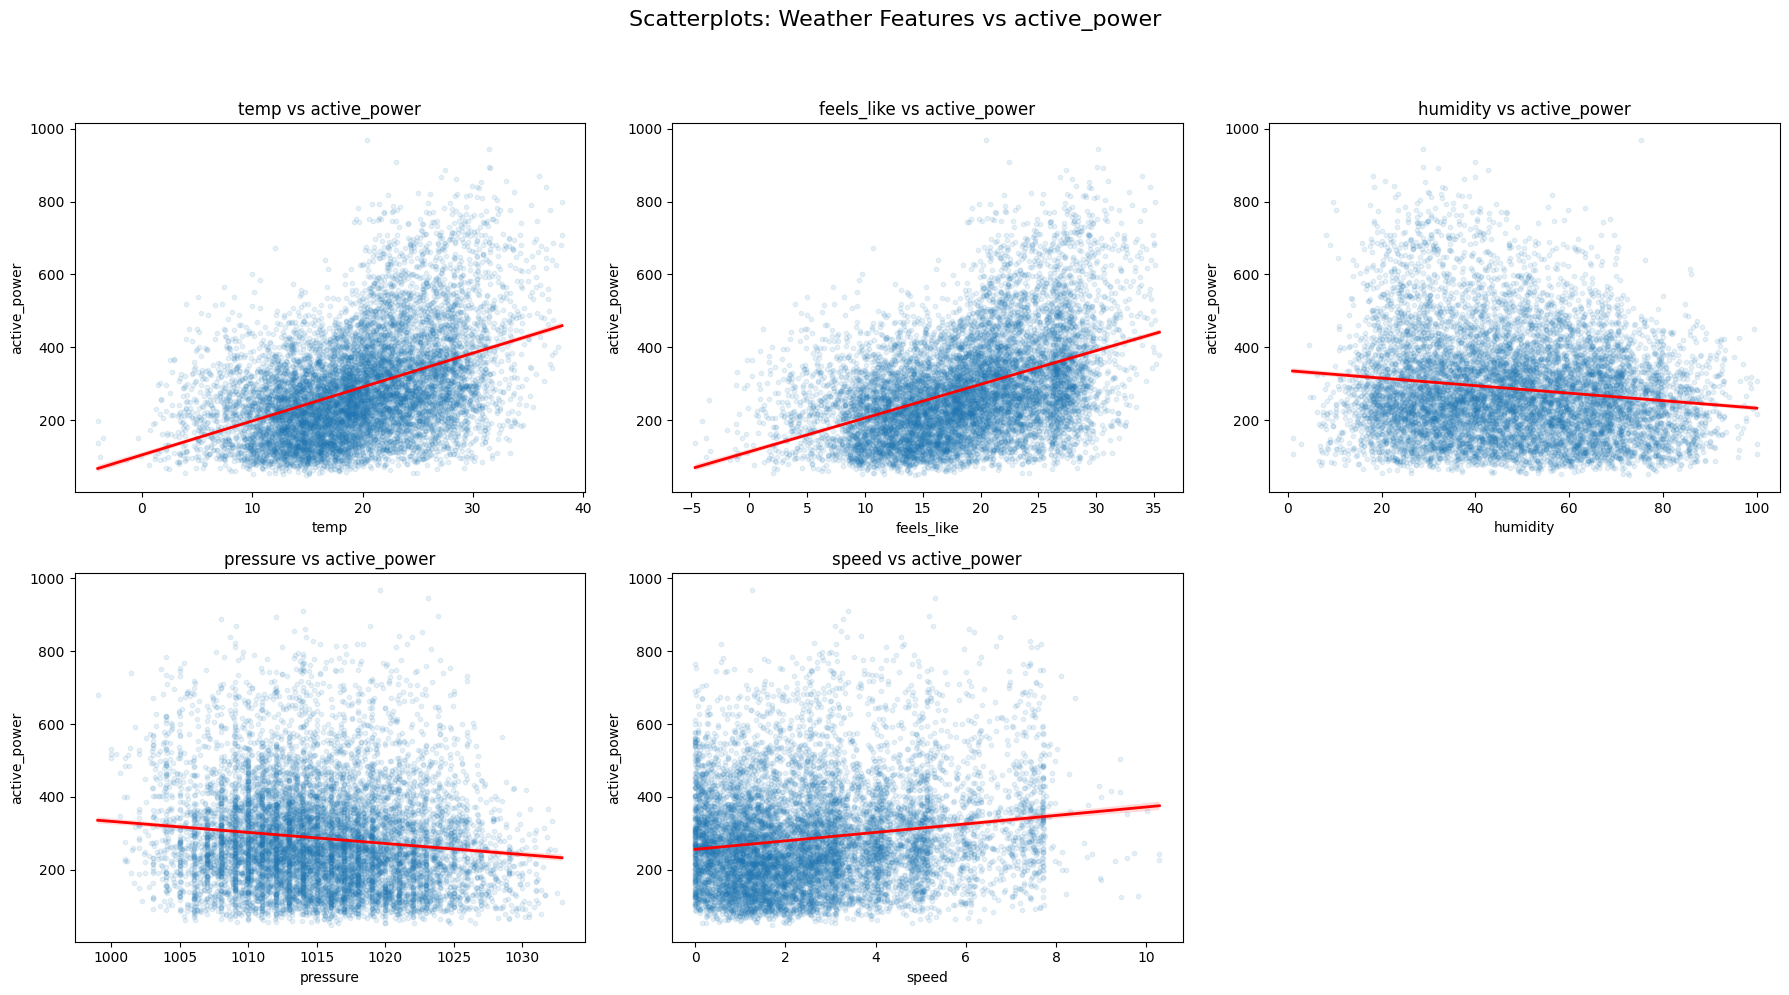

In [ ]:
print("---Scatterplot---")

plt.figure(figsize=(18, 10))
plt.suptitle(f"Scatterplots: Weather Features vs {target_feature}", fontsize=16, y=1.02)

for i, var in enumerate(weather_features):
    if var in df_hour.columns:

        plt.subplot(2, 3, i + 1)

        sns.regplot(
            data=df_hour,
            x=var,
            y=target_feature,
            line_kws={'color': 'red', 'linewidth': 2},
            scatter_kws={'alpha': 0.1, 's': 10}
        )
        plt.title(f"{var} vs {target_feature}")
        plt.xlabel(var)
        plt.ylabel(target_feature)


plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.show()

T-test p-value (weekday vs weekend): 0.2014


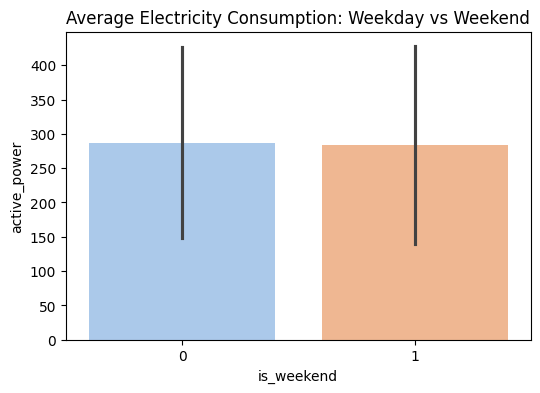

In [ ]:
grp_wd = df_hour[df_hour['is_weekend'] == 0]['active_power']
grp_we = df_hour[df_hour['is_weekend'] == 1]['active_power']
_, p_levene = levene(grp_wd, grp_we)
t_stat, p_val = ttest_ind(grp_wd, grp_we, equal_var=(p_levene>0.05))
print(f"T-test p-value (weekday vs weekend): {p_val:.4f}")

plt.figure(figsize=(6,4))
sns.barplot(x='is_weekend', y='active_power', data=df_hour, ci='sd', palette='pastel')
plt.title('Average Electricity Consumption: Weekday vs Weekend')
plt.show()

ANOVA F-statistic (7 days): 8.0923
ANOVA p-value (7 days):   9.62e-09
  -> Conclusion: There is a significant difference between the days of the week.


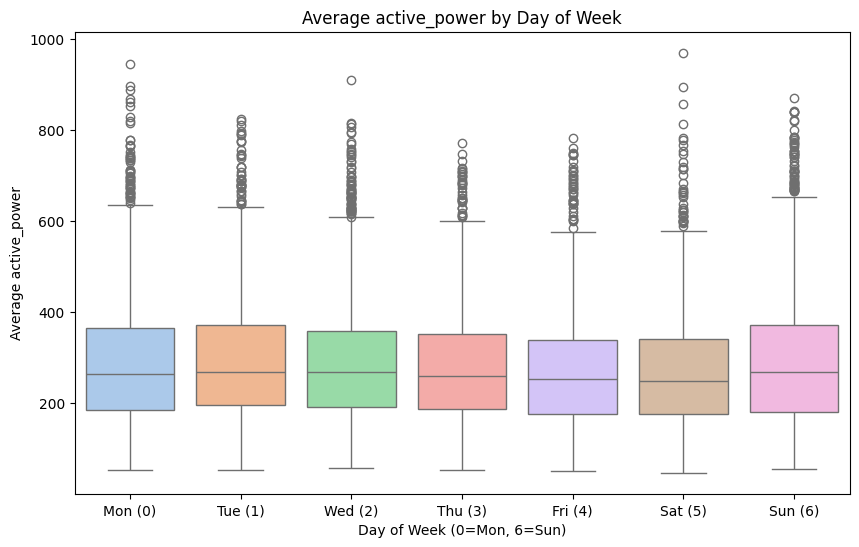

In [ ]:
target_feature = 'active_power'
groups = []
for i in range(7):
    day_data = df_hour[df_hour['weekday'] == i][target_feature].dropna()
    groups.append(day_data)
                         
f_stat, p_val = f_oneway(*groups)
                     
print(f"ANOVA F-statistic (7 days): {f_stat:.4f}")
print(f"ANOVA p-value (7 days):   {p_val:.4g}")

if p_val < 0.05:
    print("  -> Conclusion: There is a significant difference between the days of the week.")
else:
    print("  -> Conclusion: There is NO significant difference.")
                                             
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y=target_feature, data=df_hour, palette='pastel')
plt.title(f'Average {target_feature} by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel(f'Average {target_feature}')
                                   
day_labels = ['Mon (0)', 'Tue (1)', 'Wed (2)', 'Thu (3)', 'Fri (4)', 'Sat (5)', 'Sun (6)']
plt.xticks(ticks=range(7), labels=day_labels)

plt.show()